In [1]:
# Install packages
!pip install rouge-score

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
from tqdm import tqdm
import time

import tensorflow as tf
import matplotlib.pyplot as plt

import datetime as dt
import sys
import nltk.translate.bleu_score as ntbs  # BLEU scoring basics
import rouge_score.rouge_scorer as rouge_scorer  # ROUGE scoring basics
sys.path.insert(0, '../input/aida-metrics-functions')  # custom metrics implementation
import metrics as met  # custom metrics BLUE-1 pecsision and ROUGE-L recall
import json

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


# Load Captions Data

In [3]:
df_cap = pd.read_csv('../input/flickr8k/captions.txt')
df_cap.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


# Preprocess Captions

In [4]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def preproc_text(texts):
    """
    - Adds <start> to the beginning of texts to the inputs
    - Adds <end> to the end of texts
    Input: texts: list of sentences
    Output: - tokenized, padded text with <start> and <end> token             
            - tokenizer
            - max_seq_len
    """
    
    print('Creating and fitting tokenizer...')
    tokenizer_fit_data = ['<start> ' + s + ' <end>' for s in texts]

    # create tokenizer for captions + <start> and <end> tags
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(tokenizer_fit_data)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'
    print('Creating and fitting tokenizer done')
    
    print('Create sequences from texts...')        
    token_seqs = tokenizer.texts_to_sequences(tokenizer_fit_data)
    # if no "maxlen" defined then pad_sequences takes the longest sequence as max_len
    token_vecs = pad_sequences(token_seqs, padding='post')
    print('Create sequences from texts done')
    
    print('\n\n')
    print(f'preprocessed texts shape: {token_vecs.shape}')    
    
    return token_vecs, tokenizer, token_vecs.shape[-1]  # last dim is the length of the sequences        

In [5]:
token_vecs, tokenizer, max_length = preproc_text(df_cap['caption'].values)

Creating and fitting tokenizer...
Creating and fitting tokenizer done
Create sequences from texts...
Create sequences from texts done



preprocessed texts shape: (40455, 39)


# Create Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

# create 80,20 % split on the images
_, test_img_names = train_test_split(df_cap['image'].unique(), test_size=0.2, random_state=42)

df_cap['is_test'] = df_cap['image'].isin(test_img_names)

df_cap.head(2)

,image,caption,is_test
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,False
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,False


In [7]:
IMAGE_FEATURES_BASE = '../input/aida-image-captioning/Images'
IMAGES_BASE = '../input/flickr8k/Images'

In [8]:
train_token_vecs = token_vecs[df_cap[~df_cap['is_test']].index]
test_token_vecs = token_vecs[df_cap[df_cap['is_test']].index]

train_image_feature_names = df_cap[~df_cap['is_test']]['image'].map(lambda x: os.path.join(IMAGE_FEATURES_BASE, x.replace('.jpg', '.npy'))).values
test_image_feature_names = df_cap[df_cap['is_test']]['image'].map(lambda x: os.path.join(IMAGE_FEATURES_BASE,x.replace('.jpg', '.npy'))).values

In [9]:
# show shapes and one name
train_image_feature_names.shape, test_image_feature_names.shape, train_token_vecs.shape, test_token_vecs.shape, train_image_feature_names[0]

((32360,),
 (8095,),
 (32360, 39),
 (8095, 39),
 '../input/aida-image-captioning/Images/1000268201_693b08cb0e.npy')

# Create Train-Test Datasets for Tensorflow

__Currently doesn't work, continue with *Create Data Generator* (next section)__

In [10]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
EMBEDDING_DIM = 256
UNITS = 512
VOCAB_SIZE = len(tokenizer.index_word)

print(f'vocab size: {VOCAB_SIZE}')

vocab size: 8495


In [11]:
# Load the numpy files
def map_func(img_name, caption):    
    img_tensor = np.load(img_name)
    return img_tensor, caption

In [12]:
# train dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_feature_names, train_token_vecs))

# Use map to load the numpy files in parallel
train_dataset = train_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
# test dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_feature_names, test_token_vecs))

# Use map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Do not shuffle
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
BATCH_SIZE = 64
EMBEDDING_DIM = 256
UNITS = 512
VOCAB_SIZE = len(tokenizer.index_word)

# Create Enc-Dec Model with BahndanauAttention

## 1. Create Attention class

In [15]:
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K

In [16]:
class BahdanauAttention(Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = layers.Dense(units)
    self.W2 = layers.Dense(units)
    self.V = layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

## 2. Create Encoder class

In [17]:
class Feature_Encoder(Model):    
    # Works with the output features extracted from InceptionV3 trained on Imagenet
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(Feature_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

## 3. Create Decoder class

In [18]:
class Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                              return_sequences=True,
                              return_state=True,
                              recurrent_initializer='glorot_uniform')
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # apply attention on features from encoder and current hidden state
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output, state = self.gru(x)

        # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))
        
        # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

# Create Encoder & Decoder Models

In [19]:
encoder_model = Feature_Encoder(EMBEDDING_DIM)
decoder_model = Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)

# Training

In [20]:
# define optimizer
optimizer = Adam()

# define own loss function
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(targets, preds):
    loss_ = loss_object(targets, preds)
    
    mask = K.greater(targets, 0)
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy_func(targets, preds):
    real_preds = tf.cast(tf.argmax(preds, axis=-1), dtype=tf.float32)
    correct = tf.cast(tf.equal(targets, real_preds), dtype=tf.float32)
    # mask out 0 padded elements
    mask = tf.cast(tf.greater(targets, 0), dtype=tf.float32)
    n_correct = tf.sum(mask * correct)
    n_total = tf.sum(mask)
    return n_correct/n_total

In [21]:
@tf.function
def train_eval_step(img_tensor, target, is_training=True):
    loss = 0
    
    # initializing the hidden state for each batch
    # because the captions are not related from image to image
    hidden = decoder_model.reset_state(batch_size=target.shape[0])

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    
    def internal_step(img_tensor, target, dec_input, hidden, loss):
        features = encoder_model(img_tensor)
        
        # starts with 1 because we want to predict the next time step
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = decoder_model(dec_input, features, hidden)
            
            loss += loss_function(target[:, i], predictions)
            
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
            
        return loss, predictions, hidden

    if is_training:
        with tf.GradientTape() as tape:
            loss, predictions, hidden = internal_step(img_tensor, target, dec_input, hidden, loss)
            
        trainable_variables = encoder_model.trainable_variables + decoder_model.trainable_variables

        gradients = tape.gradient(loss, trainable_variables)

        optimizer.apply_gradients(zip(gradients, trainable_variables))
    else:
        loss, predictions, hidden = internal_step(img_tensor, target, dec_input, hidden, loss)
        
    total_loss = (loss / int(target.shape[1]))
    
    return loss, total_loss

In [22]:
# use checkpoint manager
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder_model,
                           decoder=decoder_model,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [23]:
ckpt_manager.latest_checkpoint

In [24]:
EPOCHS = 100
loss_plots = {'train': [], 'val': []}
train_steps = len(train_image_feature_names) // BATCH_SIZE
test_steps = len(test_image_feature_names) // BATCH_SIZE

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_eval_step(img_tensor, target, is_training=True)
        total_loss += t_loss
        
        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    
    # storing the epoch end loss value to plot later
    loss_plots['train'].append(total_loss / train_steps)

    # save the models every 5 epochs
    if epoch % 5 == 0:
        ckpt_manager.save()

    print(f'Epoch {epoch+1:3d}| training time: {time.time()-start:.2f} sec, loss {loss_plots["train"][-1]:.6f} ')

    ## validation    
    #start = time.time()
    #total_loss = 0
    #for (batch, (img_tensor, target)) in enumerate(test_dataset):
    #    batch_loss, t_loss = train_eval_step(img_tensor, target, is_training=True)
    #    total_loss += t_loss    
    ## storing the epoch end loss value to plot later
    #loss_plots['val'].append(total_loss / test_steps)
    #print(f'validation time: {time.time()-start:.2f} sec, val_loss {loss_plots["val"][-1]:.6f} ')

Epoch 1 Batch 0 Loss 2.9863
Epoch 1 Batch 100 Loss 1.4552
Epoch 1 Batch 200 Loss 1.3465
Epoch 1 Batch 300 Loss 1.1920
Epoch 1 Batch 400 Loss 1.1663
Epoch 1 Batch 500 Loss 1.1412
Epoch   1| training time: 186.79 sec, loss 1.310007 
Epoch 2 Batch 0 Loss 1.0799
Epoch 2 Batch 100 Loss 1.0502
Epoch 2 Batch 200 Loss 1.0657
Epoch 2 Batch 300 Loss 1.0764
Epoch 2 Batch 400 Loss 0.9818
Epoch 2 Batch 500 Loss 1.0079
Epoch   2| training time: 75.87 sec, loss 1.074947 
Epoch 3 Batch 0 Loss 1.0004
Epoch 3 Batch 100 Loss 1.0553
Epoch 3 Batch 200 Loss 1.0580
Epoch 3 Batch 300 Loss 0.9590
Epoch 3 Batch 400 Loss 0.9865
Epoch 3 Batch 500 Loss 1.0753
Epoch   3| training time: 74.04 sec, loss 1.005446 
Epoch 4 Batch 0 Loss 0.9848
Epoch 4 Batch 100 Loss 0.9052
Epoch 4 Batch 200 Loss 1.0621
Epoch 4 Batch 300 Loss 0.9984
Epoch 4 Batch 400 Loss 0.9328
Epoch 4 Batch 500 Loss 0.9597
Epoch   4| training time: 74.40 sec, loss 0.957525 
Epoch 5 Batch 0 Loss 0.9939
Epoch 5 Batch 100 Loss 0.9106
Epoch 5 Batch 200 Los

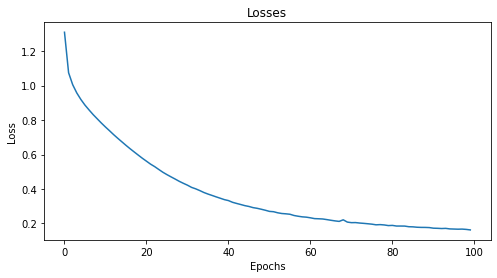

In [25]:
# show training loss plots

plt.figure(figsize=(8,4))
plt.plot(loss_plots['train'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses')
plt.show()

# Predict something from test

In [26]:
MAX_DECODER_SEQ_LEN = token_vecs.shape[-1]

def make_prediction(image_feature_path):    
    # load numpy features from input_img_feature_path
    img_tensor = np.expand_dims( np.load(image_feature_path), axis=0 )
    
    features = encoder_model(img_tensor)
    
    hidden = decoder_model.reset_state(batch_size=1)
    
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    caption = []    

    for i in range(MAX_DECODER_SEQ_LEN):
        predictions, hidden, attention_weights = decoder_model(dec_input,
                                                               features,
                                                               hidden)
        
        dec_input = tf.argmax(predictions, -1)
        word_ndx = dec_input.numpy()[0] # detach from tf
        predicted_word = tokenizer.index_word[word_ndx]
        
        if predicted_word == '<end>':
            break
        
        caption.append(predicted_word)
        
        dec_input = tf.expand_dims(dec_input, -1)

    return ' '.join(caption)

In [27]:
def eval_image_from_test(img_name):
    img = plt.imread(os.path.join(IMAGES_BASE, img_name))
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.show()
    
    print(f'\nReference captions:\n{"-"*80}')
    for l in df_cap[df_cap['image']==img_name]['caption'].values:
        print(f'- {l}')
    
    prediction = make_prediction(os.path.join(IMAGE_FEATURES_BASE, img_name.replace('.jpg','.npy')))
    print(f'\nPrediction:\n{"-"*80}')
    print(f'- {prediction}')

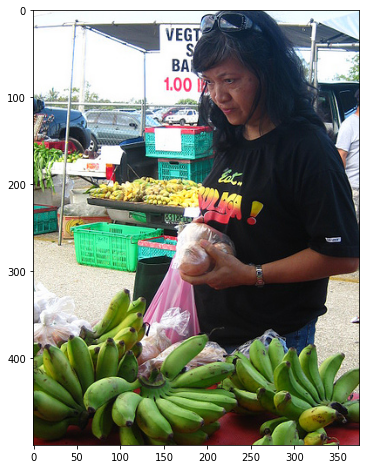


Reference captions:
--------------------------------------------------------------------------------
- An Asian woman is at a market stall that is selling bananas .
- A woman holding bags behind plantains .
- A woman in a black shirt stands in front of bananas at a fruit stand .
- A woman shops for bananas in an open-air market .
- Woman by green bananas at an open air market

Prediction:
--------------------------------------------------------------------------------
- a young woman with pink hair and an older woman in a green hat



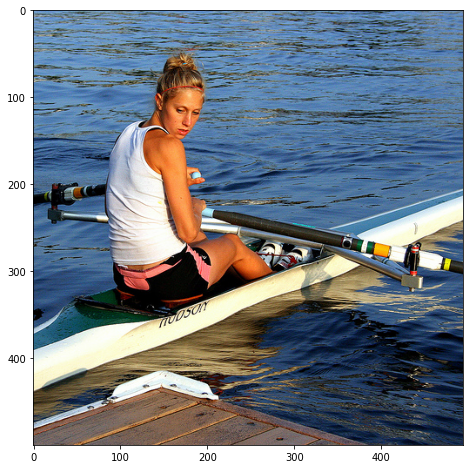


Reference captions:
--------------------------------------------------------------------------------
- A girl is rowing in a lake .
- a girl sits on a skinny canoe .
- A woman sits in a rowing scull and looks behind her at a dock .
- A woman sitting in a rowboat
- Girl in a thin rowboat leaving the dock of a lake .

Prediction:
--------------------------------------------------------------------------------
- a small boy looks up at the beach



In [28]:
num_predictions = 2
for img_file_name in df_cap[df_cap['is_test']].sample(num_predictions)['image'].values:
    eval_image_from_test(img_file_name)
    print(f'{"="*80}\n')

# Calc ROUGE-L and BLEU-1 metrics

In [29]:
## use checkpoint manager
#checkpoint_path = '../input/aida-image-capt-attention-ckpt/checkpoints/train'
#ckpt = tf.train.Checkpoint(encoder=encoder_model,
#                           decoder=decoder_model,
#                           optimizer=optimizer)
#ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)#
#
#if ckpt_manager.latest_checkpoint:    
#    # restoring the latest checkpoint in checkpoint_path
#    ckpt.restore(ckpt_manager.latest_checkpoint)  
#else:
#    print('ATTENTION: No checkpoint found!!!!!!!!!!!!!!!!!!!!!')

### Test set

In [30]:
# Prepare true captures (references) and predicted captures (candidates)
timestamp_str = None
DIR_RESULT_STORE = './results/'
if not os.path.exists(DIR_RESULT_STORE):
    os.makedirs(DIR_RESULT_STORE, exist_ok=True)


c_true_test = dict()
c_pred_test = dict()
df = df_cap.loc[df_cap.is_test == True]
for img_fname in tqdm(df.image.unique(), total=len(df.image.unique())):
    c_true_test[img_fname] = df_cap.loc[df_cap.image == img_fname].caption.to_list()
    c_pred_test[img_fname] = make_prediction(os.path.join(IMAGE_FEATURES_BASE, img_fname.replace('.jpg','.npy')))    

# Serialize data into file
if timestamp_str == None:
    timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
json.dump(c_true_test, open(DIR_RESULT_STORE + f"c_true_test_{timestamp_str}.json", 'w'))
json.dump(c_pred_test, open(DIR_RESULT_STORE + f"c_pred_test_{timestamp_str}.json", 'w'))

# Calculate Metrics
rouge_l_test, bleu_1_test = met.evaluate(c_true_test, c_pred_test)
print(f"Metrics for Testset:\nROUGE-L recall:{rouge_l_test:>10.2%}\nBLEU-1 precision: {bleu_1_test:>7.2%}")

100%|██████████| 1619/1619 [03:52<00:00,  6.97it/s]
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Metrics for Testset:
ROUGE-L recall:    30.15%
BLEU-1 precision:  31.38%


### Train set

In [31]:
c_true_train = dict()
c_pred_train = dict()
df = df_cap.loc[df_cap.is_test == False]
for img_fname in tqdm(df.image.unique(), total=len(df.image.unique())):
    c_true_train[img_fname] = df_cap.loc[df_cap.image == img_fname].caption.to_list()
    c_pred_train[img_fname] = make_prediction(os.path.join(IMAGE_FEATURES_BASE, img_fname.replace('.jpg','.npy')))

# Serialize data into file
if timestamp_str == None:
    timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
json.dump(c_true_train, open(DIR_RESULT_STORE + f"c_true_train_{timestamp_str}.json", 'w'))
json.dump(c_pred_train, open(DIR_RESULT_STORE + f"c_pred_train_{timestamp_str}.json", 'w'))

# Calculate Metrics
rouge_l_train, bleu_1_train = met.evaluate(c_true_train, c_pred_train)
print(f"Metrics for Trainset:\nROUGE-L recall:{rouge_l_train:>10.2%}\nBLEU-1 precision: {bleu_1_train:>7.2%}")

100%|██████████| 6472/6472 [13:46<00:00,  7.83it/s]
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Metrics for Trainset:
ROUGE-L recall:    51.92%
BLEU-1 precision:  52.99%


# Save Scores and model

In [32]:
# Save metrics to csv file
if timestamp_str == None:
    timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run

df = pd.DataFrame({
    "Metric": ["ROUGE-L recallt", "BLEU-1 precission"],
    "Score Test": [rouge_l_test, bleu_1_test],
    "Score Train": [rouge_l_train, bleu_1_train]}).reset_index(drop=True)

df.to_csv(DIR_RESULT_STORE + f"df_result_{timestamp_str}.csv")

In [33]:
if timestamp_str == None:
    timestamp_str = dt.datetime.now().strftime("%Y%m%d-%H%M%S")  # set timestamp for current run
    
encoder_model.save(f'{DIR_RESULT_STORE}encoder_model_{timestamp_str}.h5', save_format='h5')
decoder_model.save(f'{DIR_RESULT_STORE}decoder_model_{timestamp_str}.h5', save_format='h5')

NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.